In [2]:
#Dependencies

from skimage.external.tifffile import imread
from skimage.filters import gaussian
from skimage.exposure import equalize_adapthist

from scipy.ndimage.interpolation import rotate
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

import smtools.point_fitting as pt
import smtools.curtains as cs
from smtools.misc import straight_line

import pickle

from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
import os


def z_project(Image_list):
    result = np.zeros_like(Image_list[0])
    for Image in Image_list:
        result = result + Image/len(Image_list)
    return result.astype("uint16")

def mk_kymogram(Image_Stack,P1,P2, pad, avg_width = 3):
    X1,Y1 = P1
    X2,Y2 = P2
    S = int(np.mean([Y1,Y2]))
    tmp = []
    for frame in Image_Stack:
        local_image = frame[S-1-avg_width//2:S+avg_width//2,X1-pad:X2+pad]
        avg_slice = np.mean(local_image,axis =0)
        tmp.append(avg_slice)
    return np.array(tmp)



### Compaction analysis
---

This notebook details the method of tracking DNA compaction within a DNA curtains experiment. 

To begin, we import a stack of images containing the curtains to be tracked. Then, we average the first 10 frames of the stack to get a good, low(er) noise image of the curtain. Using this average image, we then use the curtain finder method described [here](https://github.com/ReddingLab/Learning/image-analysis-basics/5__DNA_curtain_finder_1.ipynb) to locate all of the DNA strands for tracking. 

**NOTE:** This method is variable because the curtain finder method has variance in output and detection. In addition, the function `find_rotang` has a variance in output so we are careful to only calculate it once and use the same value throughout.

In [3]:
##-- import image stack
folder = "test_stack/"
image_paths = [folder+i for i in os.listdir(folder)]
image_paths.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
images = [np.hsplit(imread(i), 2)[1] for i in image_paths if i.endswith(".tif")]

avg_initial_image = z_project(images[0:11])

#- because find_rotang has a variance in output
#- we are careful to only calculate it once.
#- see url: https://github.com/ReddingLab/Learning/image-analysis-basics/5__DNA_curtain_finder_1.ipynb
angle = np.mean([cs.find_rotang(avg_initial_image) for i in range(10)])

images_rot = [rotate(i,angle) for i in images]


In [4]:
rotated_im = rotate(avg_initial_image,angle)
bounds, mask = cs.find_curtain(rotated_im)
strands = cs.find_DNA(rotated_im,bounds)
DNA_fits = cs.fit_DNA(rotated_im, strands)
DNAs = [cs.DNA(DNA_fits[i],i) for i in range(len(DNA_fits))]


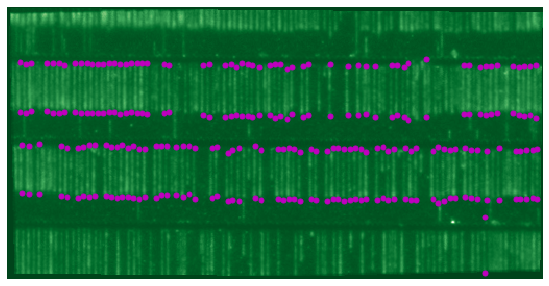

In [5]:
fig = plt.figure(figsize=(10,5))
plt.axis('off')
plt.imshow(rotate(rotated_im,-90), cmap = "Greens_r")
r,c = rotated_im.shape
for strand in DNAs:
    x1,y1 = strand.top
    x2,y2 = strand.bottom
    plt.plot([r-y1,r-y2],[(x1),(x2)],"m.", markersize = 10)
#plt.savefig("example_curtain_finder.pdf", format = "pdf")
plt.show()

Once we have each of these DNA identified, we make kymograms of each individual stand. Below are plotted a few examples chosen to highlight some of the technicalities of fitting. Also, note, we play a trick with the kymograms. Rather than just taking the slice of pixels defined by the top and bottom positions of the DNA strand from each frame and stacking them up. In this analysis, we average over the three rows of local pixels to the DNA and stack up the average slice across the frames of the data. This helps quite a bit with getting good contrast for the DNA versus background. But, it means the are more images, like shown below, with ghost compaction that we have to remove later on.

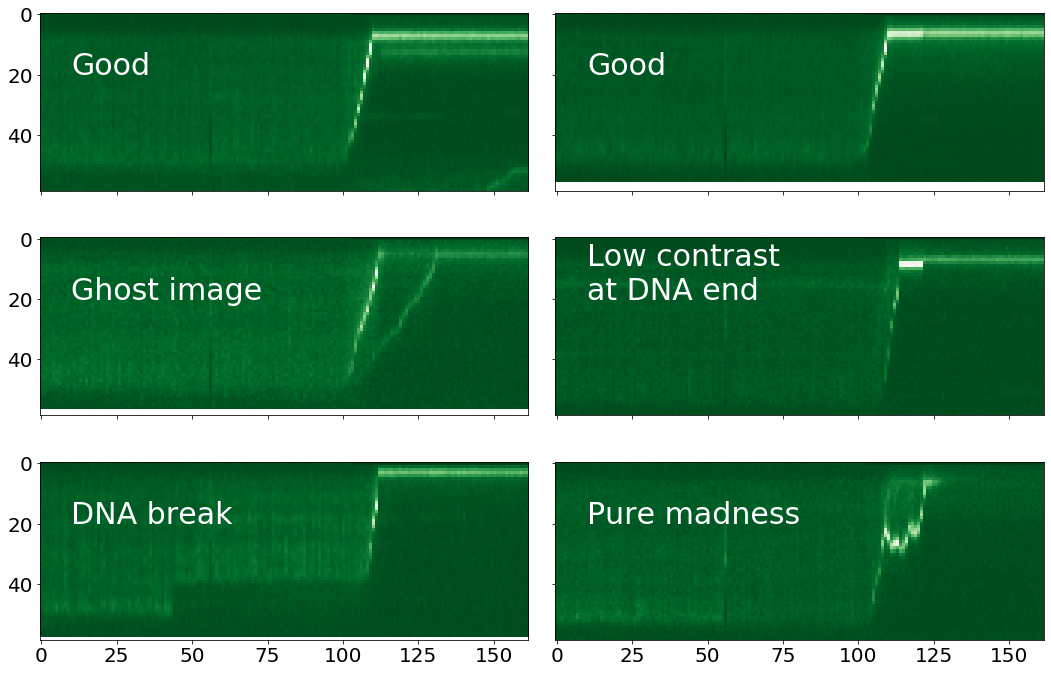

In [9]:
nrow = 3; ncol = 2;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,
                        sharex = True, sharey = True,
                        figsize = (15,10))

# NOTE: This list is unique to this notebook.
# If you re-run the curtain finder routine,
# these values will not correspond to the same 
# kymograms. Running the routine at the bottom 
# of this notebook will make all of the corresponding
# kymograms though, and the numbers can be updated.
example_list = [0,6,52,31,89,118]


text_list = ["Good", "Good",
             "Ghost image", "Low contrast \nat DNA end",
             "DNA break", "Pure madness"]

for ax,i,word in zip(axs.reshape(-1),example_list,text_list):
    strand = DNAs[i]
    x1,y1 = strand.top
    x2,y2 = strand.bottom
    x1 = int(x1)
    x2 = int(x2)
    y1 = int(y1)
    y2 = int(y2)
    kymogram = mk_kymogram(images_rot,(x1,y1),(x2,y2), 5)
    kymogram = np.flip(rotate(kymogram,-90), axis = 1)
    ax.imshow(kymogram, cmap = "Greens_r")
    ax.text(10,20,word, color = "white", fontsize = 30)

plt.tight_layout()
plt.show()
    

Once we have the kymograms, the next step is to smooth the images using a Gaussian filter. The reason we do this, is we are going to detect the leading edge of compaction by a sharp change in intensity. The smoothing ensures that the noise present in pixel to pixel variations will be less likely to be picked up as an edge.

After smoothing, then we take the derivative of the image. The derivative will likely see its highest and lowest values at the edge of the DNA where the intensity changes the most. However, in the absence of the puncta (i.e. earlier time points), the lower value is a better reporter for the DNA end, and we set the minimum value by row of the derivative filtered image as the end position of the DNA (note the axis direction, top to bottom).

In addition, we perform two additional filtering steps on the data. First, we do not survey pixels near the edge of the image. This is both because these pixels where added to the kymograms as padding for output and because we know the end of the DNA is not located off image. The second filter is to account for the fact that we expect a relatively smooth trajectory of the DNA end during compaction. To select for this, we take the positions of the DNA end as determined by the minimum of the derivative and apply a Savitzky-Golay filter. Then data points that are more than a few pixels off this smoothed line are discarded.  

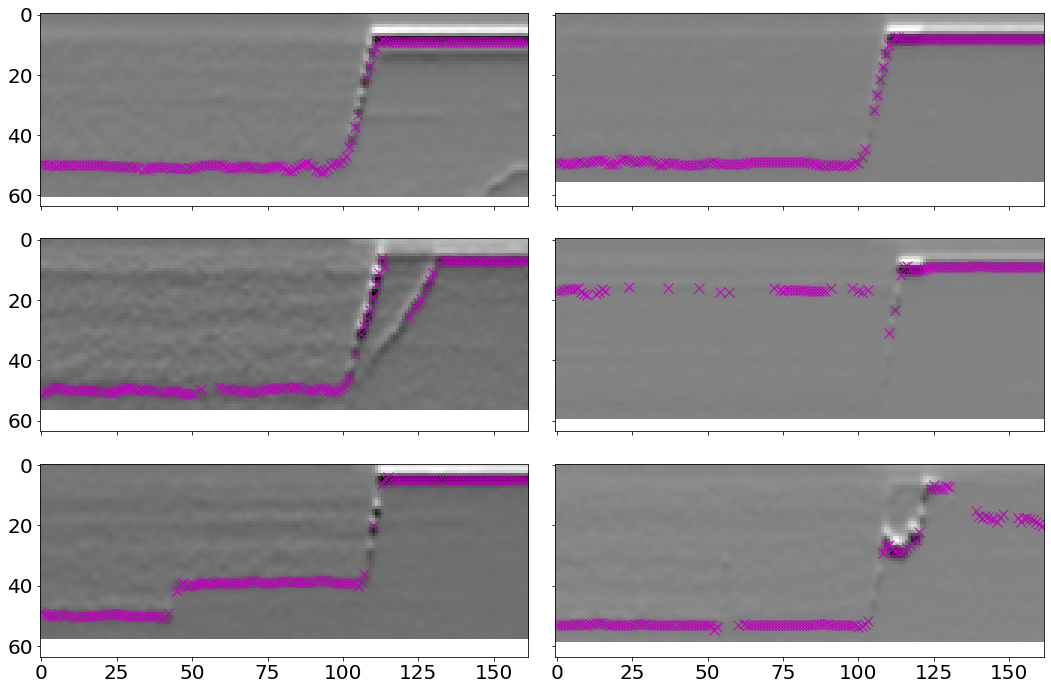

In [11]:
nrow = 3; ncol = 2;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,
                        sharex = True, sharey = True,
                        figsize = (15,10))

# NOTE: This list is unique to this notebook.
# if changed above, change here also
example_list = [0,6,52,31,89,118]
text_list = ["Good", "Good",
             "Ghost image", "Low contrast \nat DNA end",
             "DNA break", "Pure madness"]

for ax,i in zip(axs.reshape(-1),example_list):
    strand = DNAs[i]
    x1,y1 = strand.top
    x2,y2 = strand.bottom
    x1 = int(x1)
    x2 = int(x2)
    y1 = int(y1)
    y2 = int(y2)
    kymogram = mk_kymogram(images_rot,(x1,y1),(x2,y2), 5)
    kymogram = np.flip(rotate(kymogram,-90), axis = 1)
    smoothed_kymogram = gaussian(kymogram, sigma=1)
    derivative = np.gradient(smoothed_kymogram)[0]
    ax.imshow(derivative, cmap = "binary_r")
    
    
    tmp = []
    for i in range(derivative.shape[1]):
        column = derivative[:,i]
        tmp.append(np.argwhere(column == min(column[5:-5]))[0][0])
    t = [i for i in range(len(tmp))]
    y = savgol_filter(tmp, 9, 2)
    plotpts = []
    for i in range(len(tmp)):
        if abs(tmp[i]-y[i])<2:
            plotpts.append((t[i],y[i]))
        
    for i,j in plotpts:
        ax.plot(i,j,color = "m", marker = "x", 
                markersize = 10, linestyle = "None")

                


plt.tight_layout()
#plt.savefig("example_fits.pdf", format = "pdf")
plt.show()

In the general analysis pipeline, bad fits, like those in the bottom four kymograms, are removed by manual inspection. The rest of the data are then collected and analyzed further for the compaction velocity.

## Sample Analysis
----
 

Below is a sample of the analysis that we performed to determine compaction rates.

**NOTE:** as it was stated above, the routine we use to identify DNA strands is variable. This means that the kymogram numbers used to determine "good" and "poor" fits may be different if the cells of this notebook are re-run.

In [7]:
def mk_tracks(DNA_list, Image_stack, framerate, 
              pad = 5, imout = True):
    tracks = []
    for strand in DNA_list:
        x1,y1 = strand.top
        x2,y2 = strand.bottom
        x1 = int(x1)
        x2 = int(x2)
        y1 = int(y1)
        y2 = int(y2)
        kymogram = mk_kymogram(Image_stack,(x1,y1),(x2,y2), pad)
        kymogram = np.flip(rotate(kymogram,-90), axis = 1)
        smoothed_kymogram = gaussian(kymogram, sigma=1)
        derivative = np.gradient(smoothed_kymogram)[0]
        tmp = []
        for i in range(derivative.shape[1]):
            column = derivative[:,i]
            tmp.append(np.argwhere(column == min(column[pad:-pad]))[0][0])
        t = [framerate*i for i in range(len(tmp))]
        y = savgol_filter(tmp, 9, 2)
        tmp_filtered,plotpts = [],[]
        for i in range(len(tmp)):
            if abs(tmp[i]-y[i])<2:
                l_DNA = strand.bottom[0]-strand.top[0] 
                tmp_filtered.append((t[i],l_DNA+pad-y[i]))
                plotpts.append((t[i],y[i]))
        tracks.append(tmp_filtered)
        
        if imout == True:
            plt.figure()
            plt.imshow(kymogram, cmap = "Greens_r")
            for i,j in plotpts:
                plt.plot(i*10,j,color = "m", marker = "+", 
                         markersize = 2, linestyle = "None")
            try:
                plt.savefig("result_kyms/"+str(strand.id)+".png")
            except FileNotFoundError:
                os.mkdir("result_kyms")
                plt.savefig("result_kyms/"+str(strand.id)+".png")
            plt.close()
            
        
    return(tracks)

HP1_alpha_output_1 = mk_tracks(DNAs, images_rot, framerate = .1)

In [12]:
tmp = []
for strand in DNAs:
    x1,y1 = strand.top
    x2,y2 = strand.bottom
    tmp.append(x2-x1)
print("Average DNA length: ",np.mean(tmp))

Average DNA length:  48.0221300900067


In [13]:
outlist_1 = [7,8,9,12,20,31,33,38,
             52,61,73,75,77,79,80,
             85,89,91,99,101,102,105,
             108,112,116,118,124,126,
             127,128]

print("These traces excluded:  ", outlist_1)
print("Remaining traces: N = ", len(HP1_alpha_output_1)-len(outlist_1))

These traces excluded:   [7, 8, 9, 12, 20, 31, 33, 38, 52, 61, 73, 75, 77, 79, 80, 85, 89, 91, 99, 101, 102, 105, 108, 112, 116, 118, 124, 126, 127, 128]
Remaining traces: N =  99


In [14]:
count = 0
D = OrderedDict()
for trace in HP1_alpha_output_1:
    if count in outlist_1:
        pass
    else:
        for t,p in (trace):
            D.setdefault(t, []).append(p)
    count+=1
            
Averaged = sorted([(t,np.mean(p)) for t, p in D.items()], key=lambda x: x[0])
errors = sorted([(t,np.std(p)) for t, p in D.items()], key=lambda x: x[0])
t,a = map(list, zip(*Averaged))
_,s = map(list, zip(*errors))


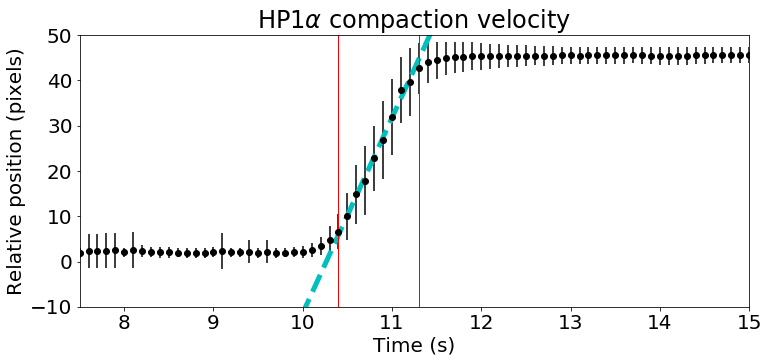

average velocity:  43.57 kbp/s


In [18]:
framerate = .1
l,r = 104,113
p, e = curve_fit(straight_line,t[l:r],a[l:r])

fig = plt.figure(figsize = (12,5))
ax1 = fig.add_subplot(111)
ax1.plot(t,straight_line(np.array(t),*p), "c--", linewidth = 5)
ax1.axvline(x=l*framerate,color = "red", linewidth = 1)
ax1.axvline(x=r*framerate,color = "red", linewidth = 1)
ax1.errorbar(t,a, yerr = s, 
             marker = "o", linestyle = "None", 
             errorevery=1, color = "k") 
ax1.set_ylim(-10,50)
ax1.set_xlim(7.5,15)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Relative position (pixels)")
ax1.set_title(r'HP1$\alpha$ compaction velocity')
plt.show()

print("average velocity: ","{:.2f}".format(p[0]*(48.502/48)),
      "kbp/s")